<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TestingNVPExtensionGaussianLikelihood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     / 10.7MB 1.2MB/s


In [0]:
import corner

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

W0504 20:18:19.345902 139765863327616 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [6]:
generator_path = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path   ='./gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
nvp_func_path      = './gdrive/My Drive/MPM/modules/gauss3b/nvp-final'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/nvp-final/

ls: cannot access './gdrive/My Drive/MPM/modules/gauss3b/nvp-final/': No such file or directory


In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [8]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [36]:
#finding EL2O 'by hand'
tf.reset_default_graph()

batch_size   = 256
batch_size_2  = 1
hidden_size   = 10
sample_size_z = 64
sigma_n       = 0.1
n_channels    = 1
num_comp      = 10

nvp_size      = [[512, 512], [512, 512], [512, 512],[512, 512], [512, 512],[512, 512]]
nvp_prior     = tf.placeholder_with_default(True,shape=[])
true_hess     = tf.placeholder_with_default(True,shape=[])



sample_size_x = tf.placeholder_with_default(10,shape=[])
lr            = tf.placeholder_with_default(0.001,shape=[])

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

generator = hub.Module(generator_path, trainable=False)
encoder   = hub.Module(encoder_path, trainable=False)
nvp_funcs = hub.Module(nvp_func_path, trainable=False)

# Define latent space prior
prior             = tfd.MultivariateNormalDiag(loc=tf.zeros([hidden_size]),scale_identity_multiplier=1.0)
log_det_prior     = tf.linalg.logdet(prior.covariance())

# data
# A) training set (used to train maf/should not be corrupted)
x_tr              = tf.placeholder(shape=[batch_size,784,n_channels], dtype=tf.float32)


prior_sample      = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)

# this is the noise of the corrupted data
sigma_corr        = tf.placeholder_with_default(np.ones([batch_size_2,784,n_channels], dtype='float32')*sigma_n,shape=[batch_size_2,784,n_channels])


# vae does mean field approximation
encoded_data      = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
mu, sigma         = tf.split(encoded_data, 2, axis=-1)
sigma             = tf.nn.softplus(sigma) + 0.0001
approx_posterior  = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[batch_size,784,1])

# uncoruppted data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
naive_recon       = likelihood_vae.mean()

# test saple from prior
prior_samples     = prior.sample(sample_size_z)
sample_liklogits  = tf.reshape(generator(prior_sample),[-1,784,n_channels])
sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()


### ---- training the nvp ----- ###

# def get_nvp():
  
#   p1 = np.arange(0,hidden_size//2)
#   p2 = np.arange(hidden_size//2,hidden_size)
#   perm=np.concatenate((p2,p1))
  
#   base_dis = tfd.MultivariateNormalDiag(loc=np.zeros(hidden_size, dtype='float32'),scale_identity_multiplier=1.0,name='base_dis')
  
#   chain = []
  
#   for i,s in enumerate(nvp_size):
#     chain.append(tfb.RealNVP(num_masked=5,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
#     chain.append(tfb.Permute(permutation=perm,name='perm%d'%i))

#   nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
#   return nvp

# def nvp_module_spec():
#     z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     sample_size  = tf.placeholder(tf.int32, shape=[])
#     u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     nvp_         = get_nvp()
#     log_prob     = nvp_.log_prob(z_sample)
#     nvp_sample   = nvp_.sample(sample_size)
#     nvp_fwd_pass = nvp_.bijector.forward(u_sample)
#     hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

# nvp_spec  = hub.create_module_spec(nvp_module_spec)
# nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

# nvp       = get_nvp()
# loss      = -tf.reduce_mean(nvp_funcs({'z_sample':approx_posterior.sample(),'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])
# optimizer = tf.train.AdamOptimizer(learning_rate=lr)
# opt_op    = optimizer.minimize(loss)

### ---- training the nvp ----- ###


### estimate the MAP for ###

# B) corrupted data from test set (networks should not have seen this before)
x_re                 = tf.placeholder(shape=[batch_size_2,784,n_channels], dtype=tf.float32)


MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size_2,hidden_size]),shape=[batch_size_2,hidden_size])
MAP                  = tf.Variable(MAP_ini)

MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))

fwd_MAP              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':MAP},as_dict=True)['fwd_pass']

# option to use uncorrected latent space
genMAP               = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_MAP), lambda: generator(MAP)),[batch_size_2,784,n_channels])

likeli_MAP           = tfd.Independent(tfd.Normal(loc=genMAP,scale=sigma_corr)).log_prob(x_re)

prior_MAP            = prior.log_prob(MAP)

posterior_MAP        = prior_MAP+likeli_MAP

loss_MAP             = -tf.reduce_mean(posterior_MAP)

opt_op2              = optimizer.minimize(loss_MAP, var_list=[MAP])

MAP_mean             = tfd.Independent(tfd.Normal(loc=genMAP,scale=sigma_corr)).mean()


##### do Laplace approximation
ini_val  = np.ones((batch_size_2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)

with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size_2,hidden_size)), dtype=np.float32)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus))
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)

update2          = tf.stop_gradient(mu_new.assign(MAP))

# this hessian computation is going to fail, for very irregular shapes around the minimum (we are not at a minimum?)
hess             = tf.hessians(-posterior_MAP,MAP)
hess             = tf.gather(hess, 0)
hess2            = tf.reduce_sum(hess, axis = 2 )

#constructing Hessian from known analytic form of posterior (this is for Gaussian likelihood+prior with unit variance)

grad_g           = tf.gather(tf.gradients(genMAP/(sigma_corr),MAP),0)

grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

one              = tf.linalg.eye(hidden_size, batch_shape=[batch_size_2])

hess_approx      = one+grad_g2

sigma_hess       = tf.cond(true_hess, lambda: tf.linalg.inv(hess2), lambda: tf.linalg.inv(hess_approx))

update3          = sigma_new_t2.assign(tf.linalg.cholesky(sigma_hess))

lap_z_samples    = tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size])

lap_liklogits    = tf.reshape(generator(lap_z_samples),[-1,784,n_channels])
lap_likelihood   = tfd.Independent(tfd.Normal(loc=lap_liklogits,scale=sigma_corr))
lap_mean         = lap_likelihood.mean()
lapl_variance_MAP= tf.linalg.diag_part(approx_posterior_laplace.covariance())


# # # construct a GMM approximation from different minima

# with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
#   mu_gmm      = tf.Variable(np.ones((batch_size_2,num_comp,hidden_size)), dtype=np.float32)
#   ini_val2    = np.ones((batch_size_2,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
#   sigma_gmm   = tf.constant(ini_val2)
#   sigma_gmmt  = tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_gmm), transform=tf.nn.softplus))
#   w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)

# mu_est        = tf.placeholder_with_default(tf.zeros([batch_size_2,num_comp,hidden_size]),shape=[batch_size_2,num_comp,hidden_size])
# sigma_est     = tf.placeholder_with_default(tf.ones([batch_size_2,num_comp,hidden_size, hidden_size]),shape=[batch_size_2,num_comp,hidden_size, hidden_size])
# w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

# update_a      = w_gmm.assign(w_est)
# update_b      = mu_gmm.assign(mu_est)
# update_c      = sigma_gmmt.assign(sigma_est)

# gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

# gmm_sample_z  = gmm.sample(sample_size_z)
# #gmm_sample_x  = tfd.Independent(tfd.Normal(loc=tf.reshape(generator(gmm_sample_z),[-1,784,n_channels]),scale=sigma_corr)).mean()

# saver         = tf.train.Saver()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0504 20:31:45.534843 139765863327616 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0504 20:31:45.594623 139765863327616 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0504 20:31:45.679865 139765863327616 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0504 20:31:46.457232 139765863327616 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0504 20:31:46.542744 139765863327616 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0504 20:31:46.588081 139765863327616 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0504 20:31:49.199989 139765863327616 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

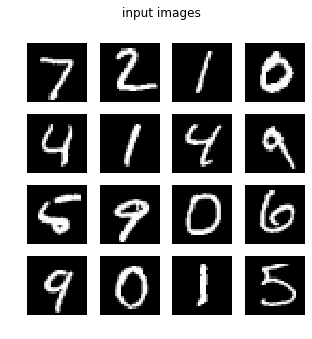

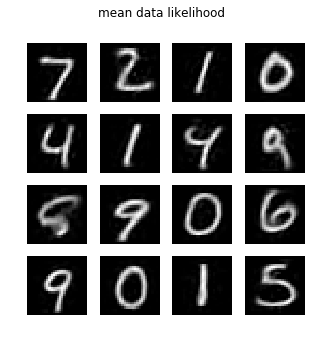

In [39]:
samples = sess.run(prior_samples, feed_dict={x_tr: np.expand_dims(x_truth,-1)})
samples.shape
inim, res = sess.run([x_tr,naive_recon], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_sample: samples})
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(res[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
posterior_loss=[]
ii     = 0
nepoch = 0
learning_rate=1e-3

In [222]:
#train the nvp
while nepoch<1000:
  if (ii+1)*batch_size>len(x_train): 
    ii=0
    nepoch+=1
    print('starting epoch', nepoch)
  if nepoch>200:
    learning_rate=1e-5
  x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
  _, ll = sess.run([opt_op,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
  posterior_loss+=[ll]
  if ii%500==0:
    print(ll)
  ii+=1

13.93687
starting epoch 1
10.837847
starting epoch 2
10.32632
starting epoch 3
10.092486
starting epoch 4
9.910723
starting epoch 5
9.773926
starting epoch 6
9.662037
starting epoch 7
9.565801
starting epoch 8
9.494173
starting epoch 9
9.450555
starting epoch 10
9.35394
starting epoch 11
9.259221
starting epoch 12
9.228304
starting epoch 13
9.191933
starting epoch 14
9.188835
starting epoch 15
9.119191
starting epoch 16
9.1023445
starting epoch 17
9.076588
starting epoch 18
9.096464
starting epoch 19
9.077827
starting epoch 20
8.957333
starting epoch 21
8.917731
starting epoch 22
8.957078
starting epoch 23
8.982838
starting epoch 24
8.937468
starting epoch 25
8.873636
starting epoch 26
8.902088
starting epoch 27
8.926103
starting epoch 28
8.902695
starting epoch 29
8.80893
starting epoch 30
8.914626
starting epoch 31
8.812485
starting epoch 32
8.783049
starting epoch 33
8.754967
starting epoch 34
8.800301
starting epoch 35
8.778905
starting epoch 36
8.742828
starting epoch 37
8.770473


KeyboardInterrupt: ignored

(6, 10)

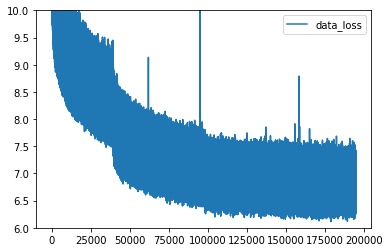

In [151]:
plt.figure()
plot(posterior_loss[::],label='data_loss')
legend()
plt.ylim(6,10)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0504 20:26:10.296982 139765863327616 saver.py:1483] Saver not created because there are no variables in the graph to restore


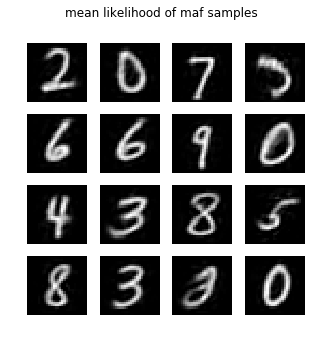

In [21]:
samples1 = sess.run(nvp_funcs({'z_sample':approx_posterior.sample(),'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])

s = sess.run(sample_mean, feed_dict={prior_sample: samples1})

figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:

#nvp_funcs.export(nvp_func_path,sess)


In [22]:
maf_s, prior_s = sess.run([nvp_funcs({'z_sample':approx_posterior.sample(),'sample_size':10000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'], prior.sample(10000)])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0504 20:26:23.228081 139765863327616 saver.py:1483] Saver not created because there are no variables in the graph to restore


(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


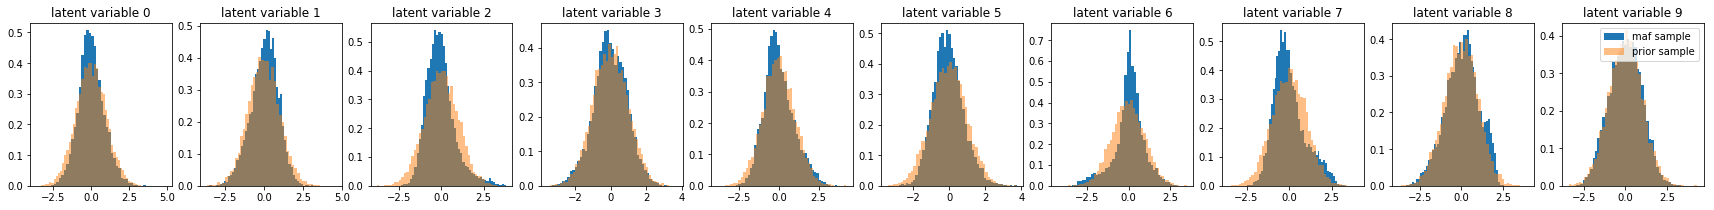

In [157]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

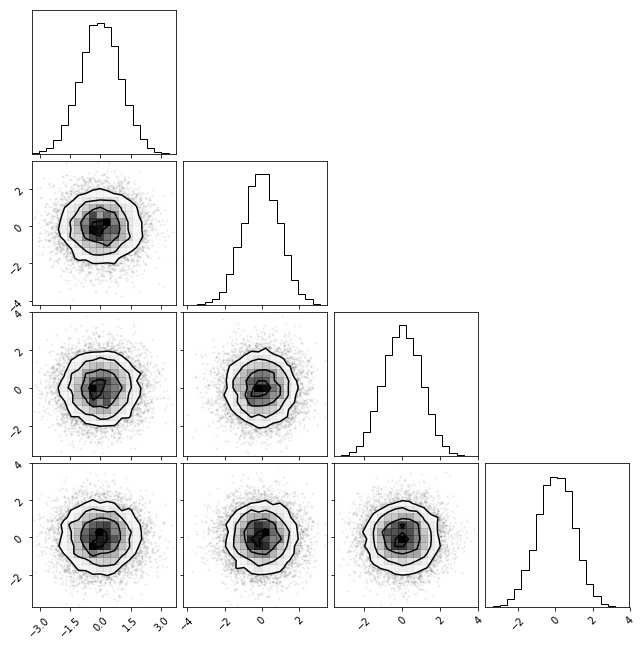

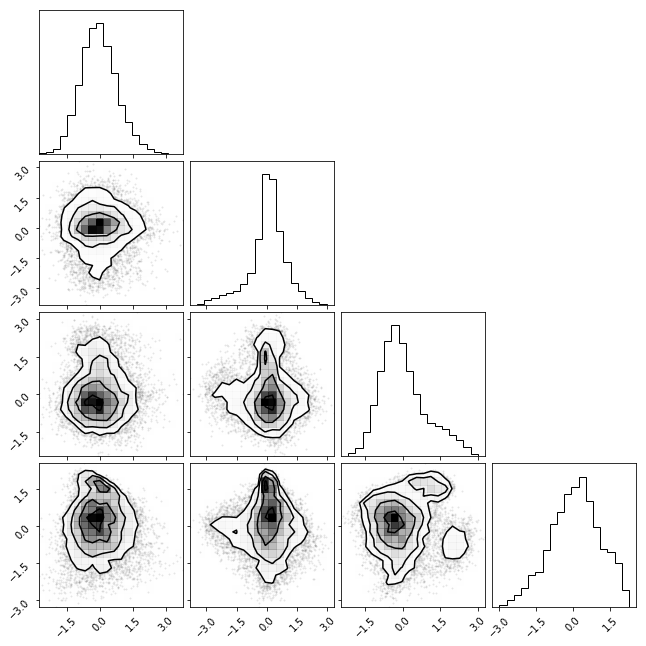

In [158]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])

In [0]:
inc = 6
x_truth   = x_test[inc:batch_size_2+inc]
sigma_new = np.ones([28,28])*sigma_n
sigma_new[0:28,12:18]=1e8
mask=np.ones([28,28])
mask[np.where(sigma_new==1e8)]=0

data        = np.expand_dims(x_truth,-1)
sigma_new   = sigma_new.reshape([batch_size_2,784,n_channels])
mask        = mask.reshape([batch_size_2,784,n_channels])
data        = data*mask

0
4265.9243
3543.6975
3485.542
3466.8032
3454.0017
3441.1245
3425.5605
3424.3005
3423.2966
3422.4756
3423.1653
3421.013
3420.2112
3419.6208
3418.8447
3418.394
3419.5288
3417.8179
3417.0967
3414.1624
switching to lr 0.01
3410.7993
3407.676
3407.0383
3405.5781
3402.3103
3390.4924
3388.2417
3386.9023
3385.5142
3385.421
switching to lr 0.001
3383.6814
3383.294
3382.6865
3382.26
3381.56
1
4614.804
4174.096
4134.3467
4109.188
4016.186
3949.9998
3861.1724
3678.469
3601.2996
3534.4941
3525.3323
3519.129
3508.7117
3501.1814
3495.236
3484.9524
3476.937
3470.8945
3464.886
3460.4973
switching to lr 0.01
3456.0195
3448.866
3432.9749
3428.906
3424.7283
3421.4868
3404.812
3391.218
3385.7812
3385.4697
switching to lr 0.001
3385.4128
3385.4163
3385.4116
3385.4084
3385.404
2
4518.9277
3798.4036
3176.8113
3131.2903
3075.093
2935.2144
2902.894
2900.0298
2870.0405
2846.6873
2839.9575
2820.8706
2813.4028
2810.7202
2808.0662
2805.9363
2804.0771
2801.3918
2798.9343
2796.592
switching to lr 0.01
2794.408
2784.

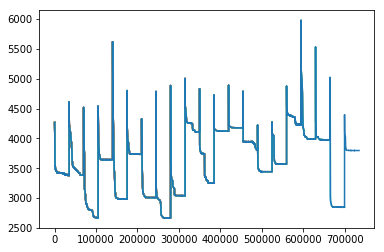

In [44]:
posterior_loss2=[]
ini = np.zeros((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))

l_minima=[]
map_minima=[]
for ii in range(21):
  print(ii)
  if ii ==0:
    ini = np.zeros((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))
  else:
    ini = np.random.randn((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(20000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  print('switching to lr', lrate)
  for ii in range(10000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for ii in range(5000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  plot(posterior_loss2,label='data_loss')
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={x_re: data, sigma_corr:sigma_new})]

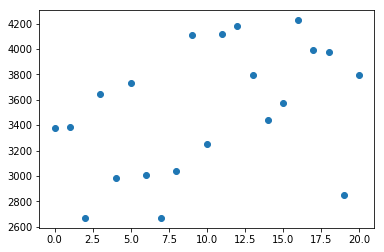

In [45]:
plt.figure()
plt.plot(np.arange(21),l_minima,ls='',marker='o')
plt.show()

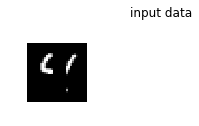

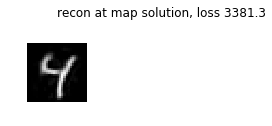

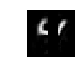

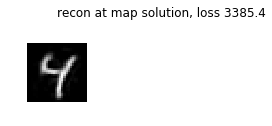

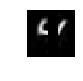

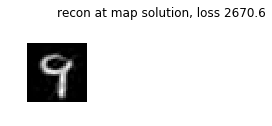

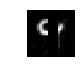

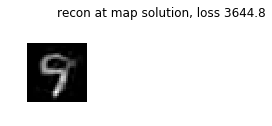

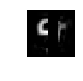

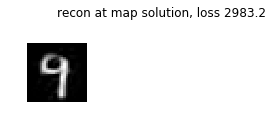

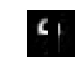

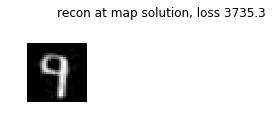

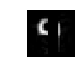

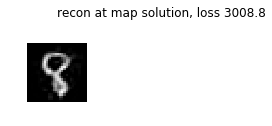

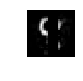

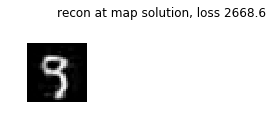

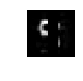

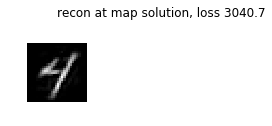

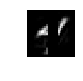

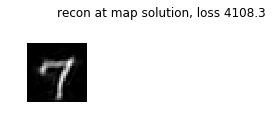

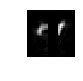

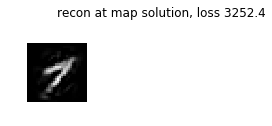

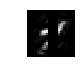

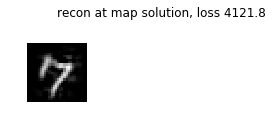

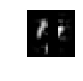

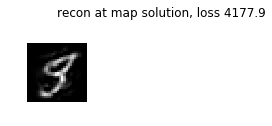

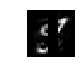

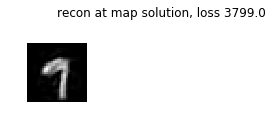

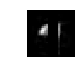

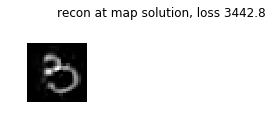

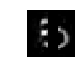

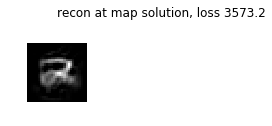

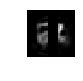

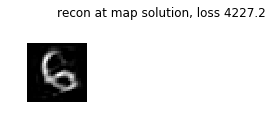

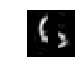

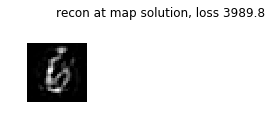

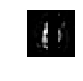

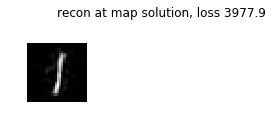

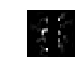

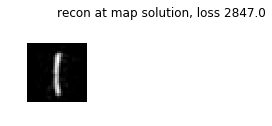

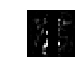

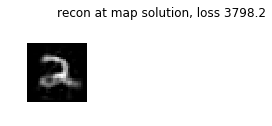

[[[ 1.14151335e+00 -1.26538545e-01 -1.08231880e-01  2.96682954e-01
   -6.82758987e-02 -1.14056349e-01 -2.28722133e-02 -1.16719626e-01
    9.15417820e-02  1.68733485e-02]
  [-1.26543984e-01  9.80775654e-02 -3.69283184e-02 -6.91803694e-02
   -8.87865201e-03  3.47218551e-02  4.65849973e-02  2.34478246e-02
   -1.16972625e-02  4.74761194e-03]
  [-1.08231276e-01 -3.69283706e-02  6.79253489e-02  1.51234418e-02
    3.10035050e-03 -9.73770395e-03 -2.86474079e-02 -1.49318576e-03
   -4.40477580e-03 -1.97674166e-02]
  [ 2.96674997e-01 -6.91747218e-02  1.51211983e-02  2.51331478e-01
   -1.14662029e-01 -7.41069466e-02 -4.96242456e-02 -9.44538787e-02
    2.60309391e-02 -2.26577166e-02]
  [-6.82608709e-02 -8.88217613e-03  3.10078636e-03 -1.14656702e-01
    1.16164327e-01  3.63927186e-02  6.37592375e-03  4.86241616e-02
   -5.51828044e-03  1.12758381e-02]
  [-1.14053130e-01  3.47203799e-02 -9.73753072e-03 -7.41075873e-02
    3.63947228e-02  2.89015211e-02  1.82002280e-02  2.82135569e-02
   -1.02922525e-

InvalidArgumentError: ignored

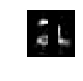

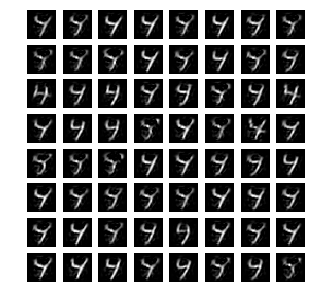

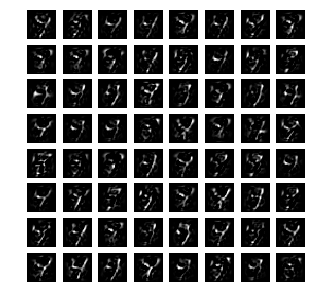

In [49]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')


order = np.argsort(l_minima)
for ii,ini_ in enumerate(map_minima[order]):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new})
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size_2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask[0,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')


varis=[]  
for ii,ini_ in enumerate(map_minima[order]):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new})   
  _ = sess.run(update2,feed_dict={x_re: data, sigma_corr:sigma_new})
  print(sess.run(sigma_hess,feed_dict={x_re: data, sigma_corr:sigma_new}))
  _ = sess.run(update3,feed_dict={x_re: data, sigma_corr:sigma_new})
  
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_re: data, sigma_corr:sigma_new})]
  
  #z_samples = sess.run(lap_z_samples,feed_dict={x_re: data, sigma_corr:sigma_new})
  l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new})
  figure(figsize=(5,5))
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  figure(figsize=(5,5))
  mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))
  for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(l_samples[i,:,0],(28,28))-mean_sample,cmap='gray',vmin=0)
    axis('off')    


(21, 1, 1, 10)


IndexError: ignored

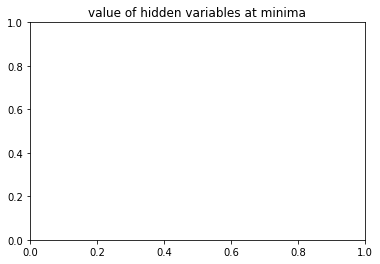

In [47]:
varis=np.asarray(varis)
map_minima=np.asarray(map_minima)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima)):
  print(map_minima.shape)
  yerr_= np.sqrt(varis[ii,0])
  print(len(yerr))
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

0
4290.7666
3970.183
3969.802
3969.7864
3969.7888
3969.7832
3969.7856
3969.781
3969.7974
3969.804
1
5099.7524
3135.977
3045.306
3036.0308
3036.0303
3036.0444
3036.0417
3036.019
3036.02
3036.0432
2
6121.2637
3608.857
3385.7532
3361.5356
3361.4863
3361.499
3361.5012
3361.5063
3361.4915
3361.4949
3
3727.694
3167.003
3166.99
3166.991
3166.9805
3166.9905
3166.9795
3166.9902
3166.998
3166.9858
4
5386.545
3736.0122
3733.8838
3733.7935
3733.8035
3733.818
3733.885
3733.793
3733.9104
3733.9304
5
4808.3022
3030.8179
3011.4495
2918.702
2711.6404
2653.5024
2653.4521
2653.4426
2653.4678
2653.4758
6
5247.2476
4128.208
4124.7
4124.69
4124.703
4124.721
4124.7197
4124.705
4124.705
4124.722
7
4986.698
3485.535
3398.7654
3359.188
3358.3906
3358.3574
3358.361
3358.3674
3358.3638
3358.3577
8
4763.665
3046.2126
2661.7651
2660.038
2658.7883
2658.7878
2658.7898
2658.7935
2658.7908
2658.7947
9
5392.6836
2878.2942
2870.8765
2870.827
2870.8367
2870.82
2870.8394
2870.8413
2870.8464
2870.8186


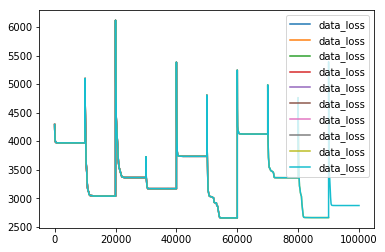

In [0]:
l_minima_old=[]
map_minima_old=[]
posterior_loss3=[]
for ii in range(10):
  print(ii)
  ini = np.random.randn((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini, maf_prior: False, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(3000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, maf_prior: False, sigma_corr:sigma_new})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  for ii in range(5000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, maf_prior: False, sigma_corr:sigma_new})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-4
  for ii in range(2000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, maf_prior: False, sigma_corr:sigma_new})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  l_minima_old+=[ll]
  map_minima_old+=[sess.run([MAP],feed_dict={x_re: data, sigma_corr:sigma_new, maf_prior: False})]
  plot(posterior_loss3,label='data_loss')
  legend()

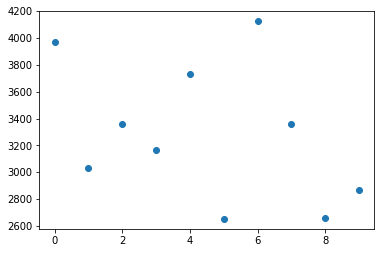

In [0]:
plt.figure()
plt.plot(np.arange(10),l_minima_old,ls='',marker='o')
plt.show()

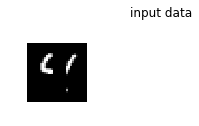

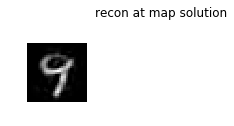

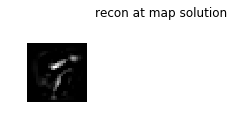

In [0]:
mean_at_map_2 = sess.run(MAP_mean,feed_dict={x_re: data, maf_prior: False, sigma_corr: sigma_new})



figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')

figure(figsize=(5,5))
suptitle('recon at map solution')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean_at_map_2[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
    

figure(figsize=(5,5))
suptitle('recon at map solution')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape((mean_at_map-mean_at_map_2)[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')

In [219]:
for ii,ini_ in enumerate(map_minima_old):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new,maf_prior: False})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima_old[ii])
  for i in range(min(batch_size_2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')


varis=[]
for ii,ini_ in enumerate(map_minima_old):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new,maf_prior: False})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})
  _ = sess.run(update2,feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})
  _ = sess.run(update3,feed_dict={x_re: data, sigma_corr:sigma_new, maf_prior: False})
  l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_re: data, sigma_corr:sigma_new,maf_prior: False})]
  #print(l_samples.shape)
  figure(figsize=(5,5))
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  figure(figsize=(5,5))   
  mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))
  for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(l_samples[i,:,0],(28,28))-mean_sample,cmap='gray',vmin=0)
    axis('off')    
    

NameError: ignored

W0503 07:09:13.611931 139770617186176 legend.py:1289] No handles with labels found to put in legend.


(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10
(10, 1, 1, 10)
10


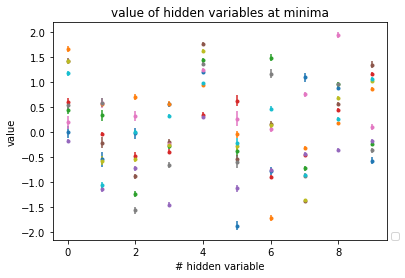

In [0]:
varis=np.asarray(varis)
map_minima_old=np.asarray(map_minima_old)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima_old)):
  print(map_minima_old.shape)
  yerr_= np.sqrt(varis[ii,0])
  print(len(yerr))
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima_old[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()